In [1]:
from IPython.display import Image
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
# sns.set_style("whitegrid")
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
%matplotlib inline

# Setting up a machine learning problem

## Goals for today

- How do we evaluate a model?

- How do we choose an appropriate model?

- How can we ensure our model works well on unseen data (ie. in the real world)?


## Types of machine learning

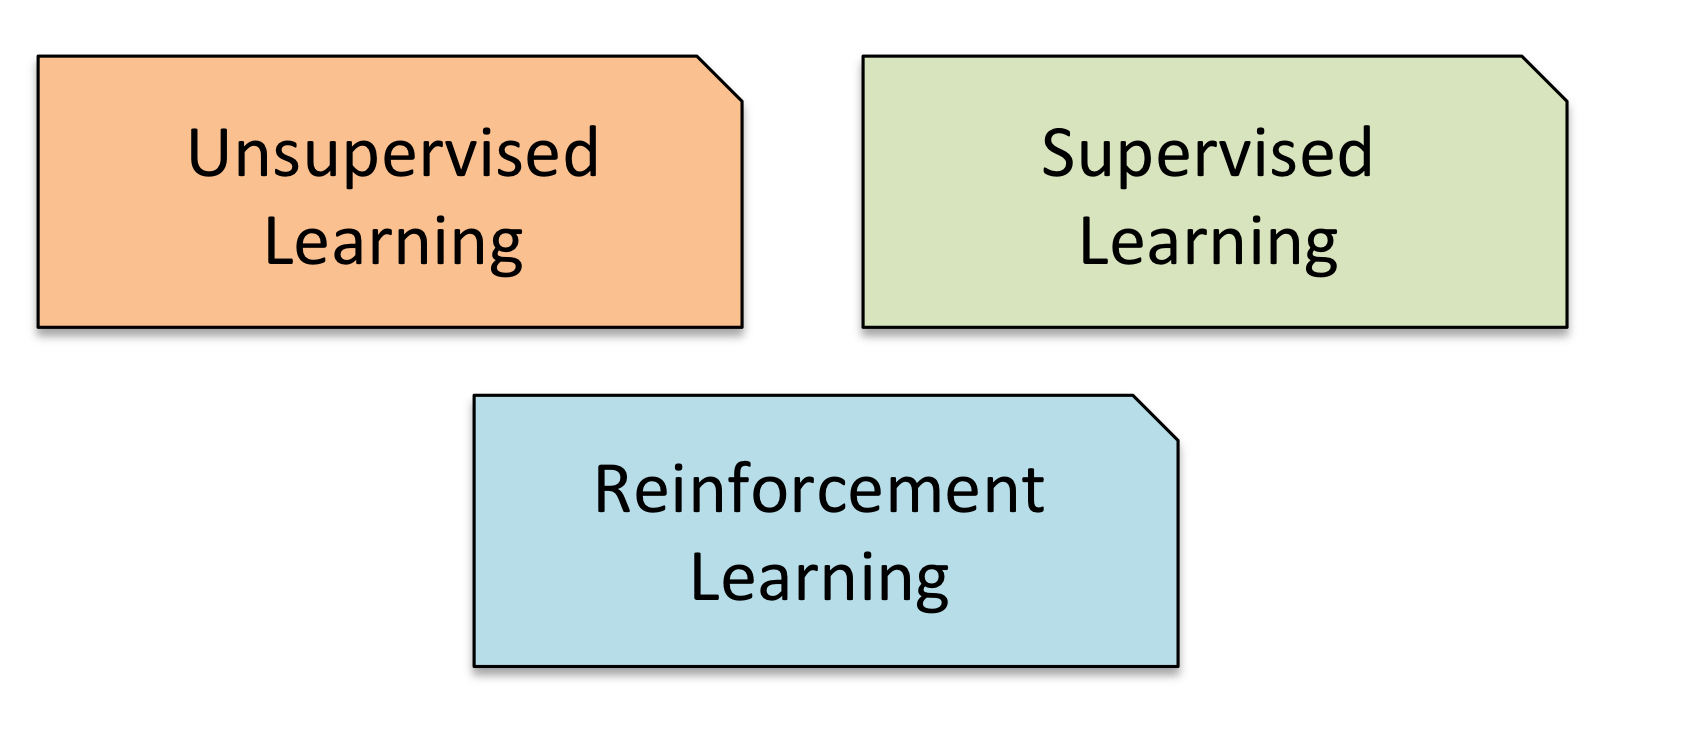

In [2]:
Image(filename='ml_types.png', width=800) 

## Making predictions about the future with supervised learning

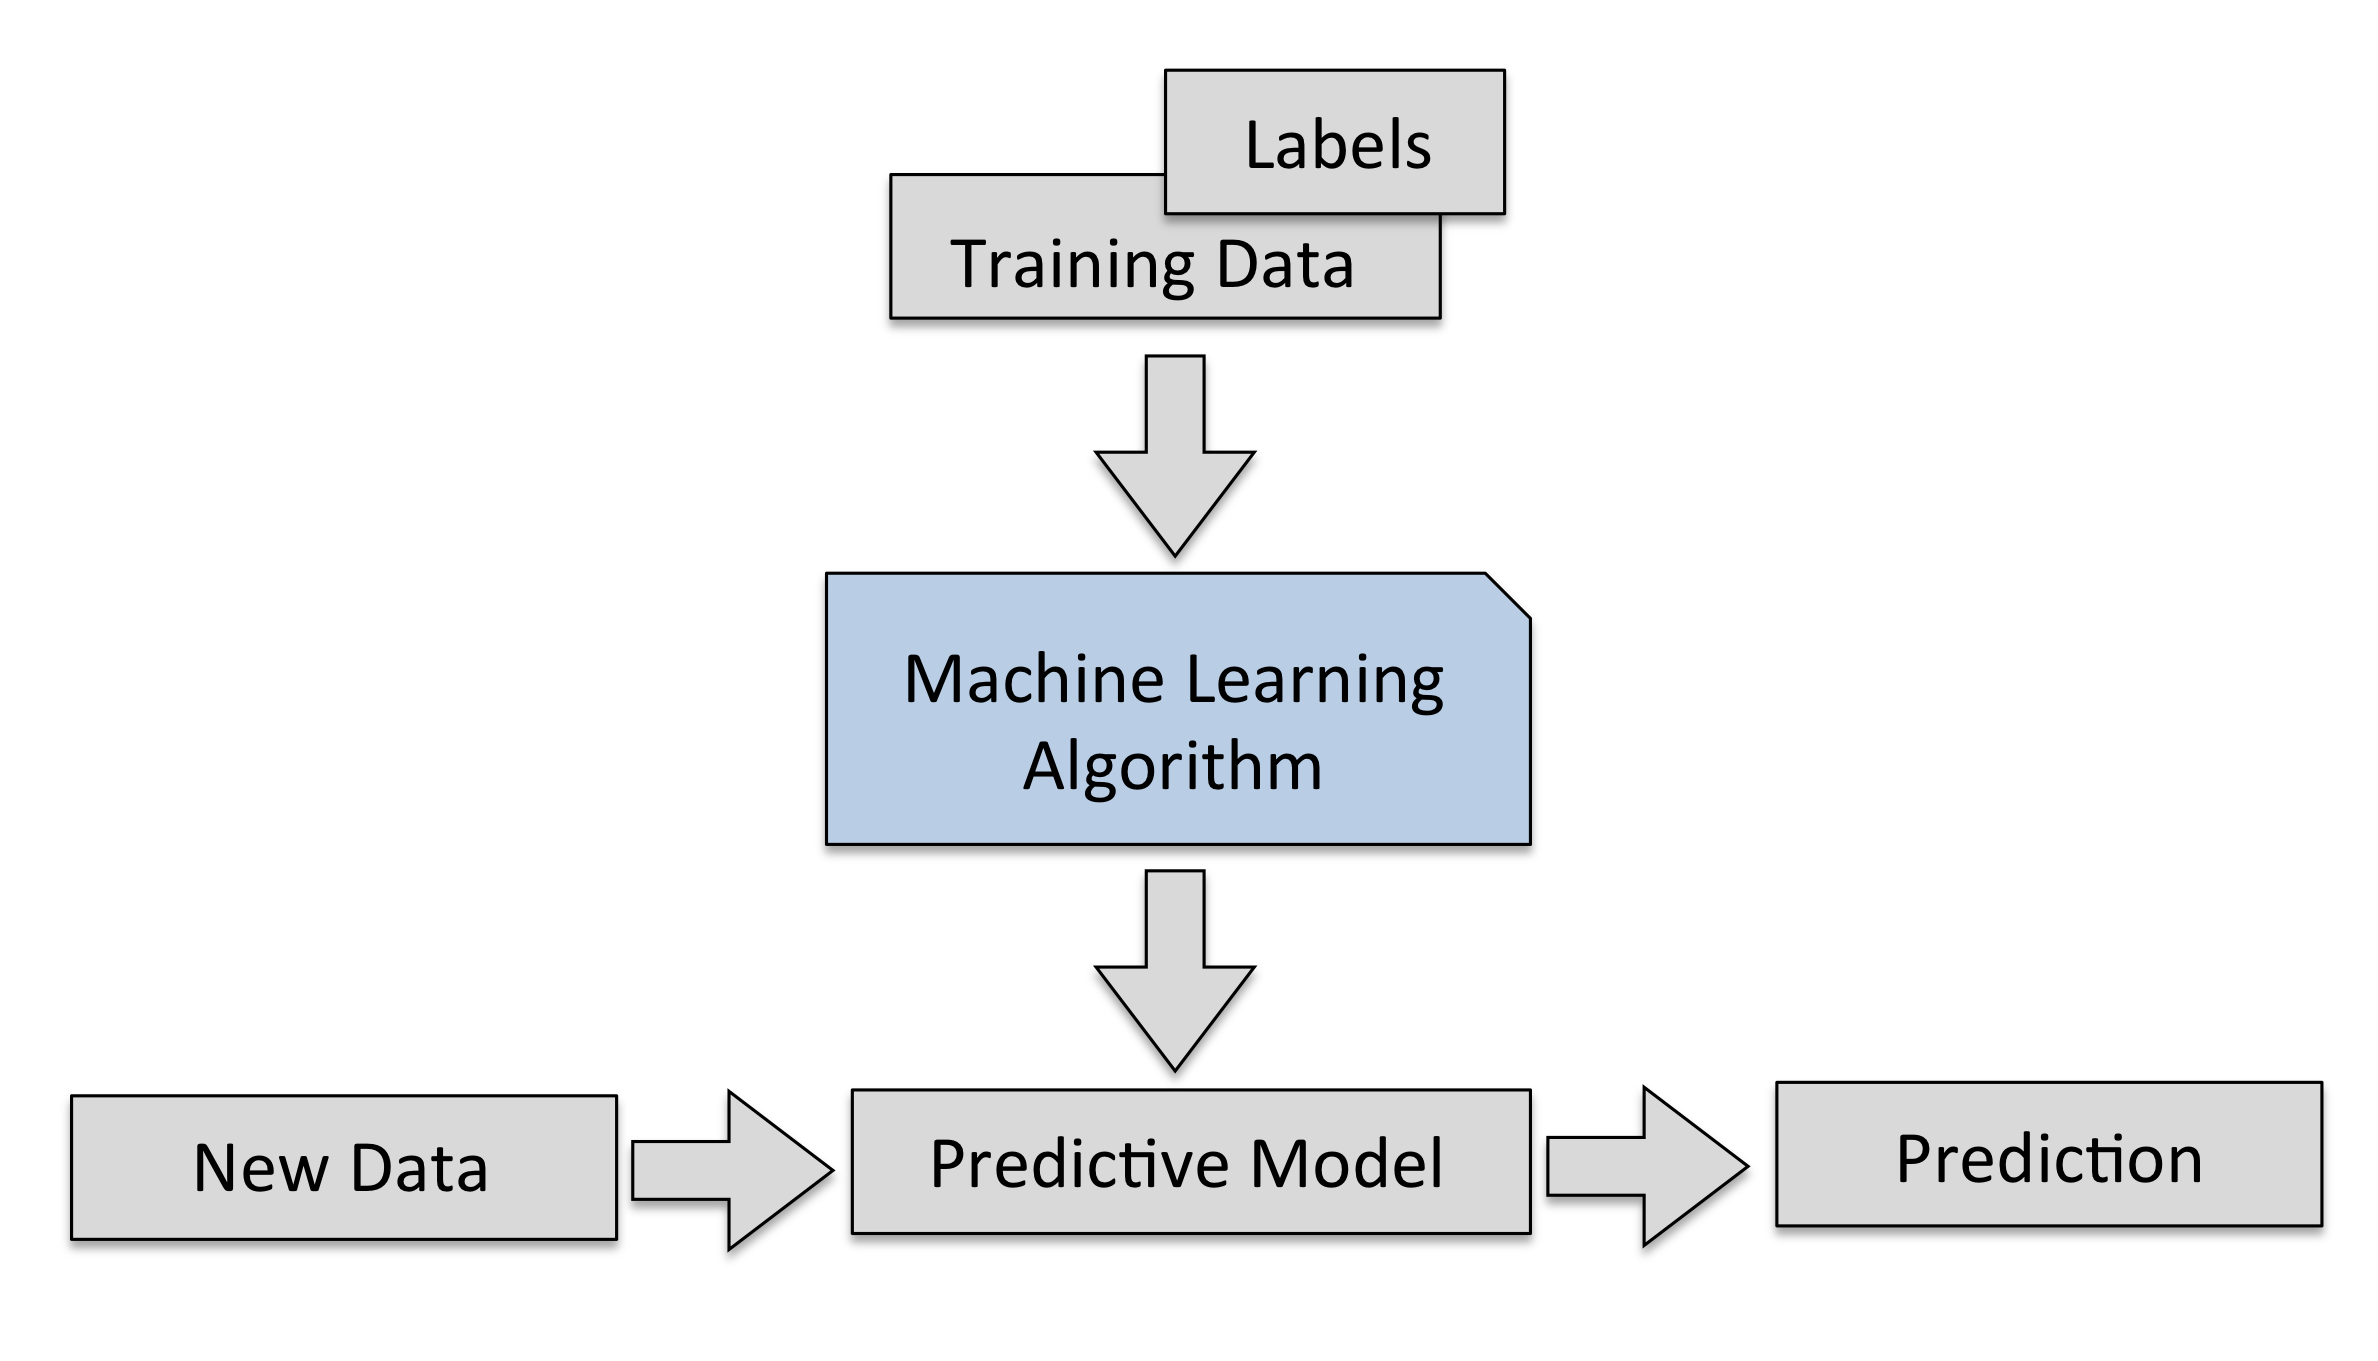

In [3]:
Image(filename='supervised_pipeline.png', width=800) 

## Let's work through an example
- We are given a univariate continuous data set 

- This might represent house pricing as a function of the population density, or machine output as a function of temperature. 

- If we are able to predict the behaviour this might give us a competitive edge, or better plan our resource spending

In [4]:
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples)*100)
true_fun = lambda X: (-np.cos(1.5 * np.pi * (X/100))  + 3) *100
y = true_fun(X) + np.random.randn(n_samples) * 25

X = np.sort(np.random.rand(n_samples))
true_fun = lambda X: (np.cos(1.5 * np.pi * (X)))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

In [5]:
def formatGraph():
    plt.xlabel('x'); plt.ylabel('y')
    plt.xlim([0, 1])
    plt.ylim([-1, 1])
    plt.legend(loc="lower left")
    plt.tight_layout()

# The data

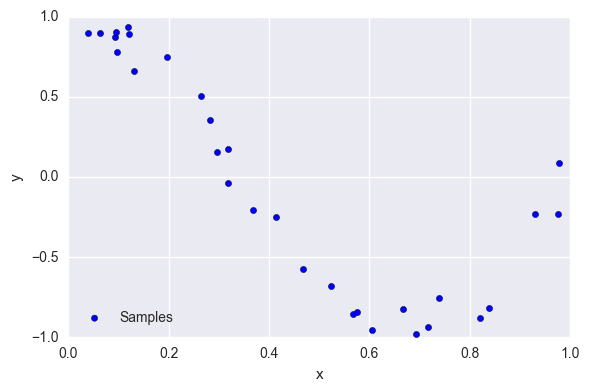

In [17]:
plt.scatter(X, y, label="Samples")
formatGraph()

## Where to start... how about a line!

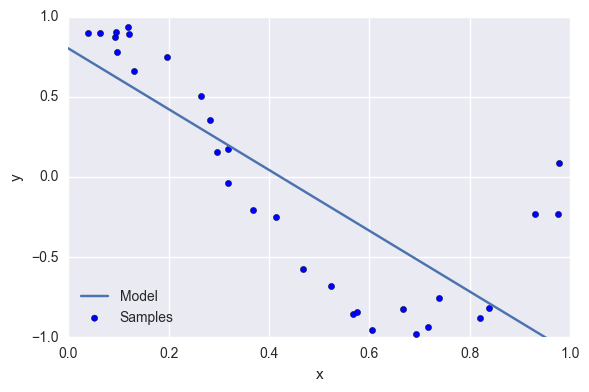

In [7]:
linear_regression = LinearRegression()
linear_regression.fit(X[:, np.newaxis], y)
X_test = np.linspace(0, 1, 100)
plt.plot(X_test, linear_regression.predict(X_test[:, np.newaxis]), label="Model")
plt.scatter(X, y, label="Samples")
formatGraph()

## How can we evaluate this model?
$$ MSE(y, \hat{y}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}-1}(y_i - \hat{y}_i)^2$$

In [8]:
mean_squared_error(y, linear_regression.predict(X[:, np.newaxis]))

0.17969508465274686

## What's Next?
- Our model missed some of the nonlinearity in the data (could look at a plot of the residuals to confirm this)
- Looks to be underfitting the data (high bias)
- Let's try a more complex polynomial model:

$$ \hat{y}_n(w, x) = w_0 + w_1x + w_2x^2 + w_3x^3 + .. + w_nx^n$$ 

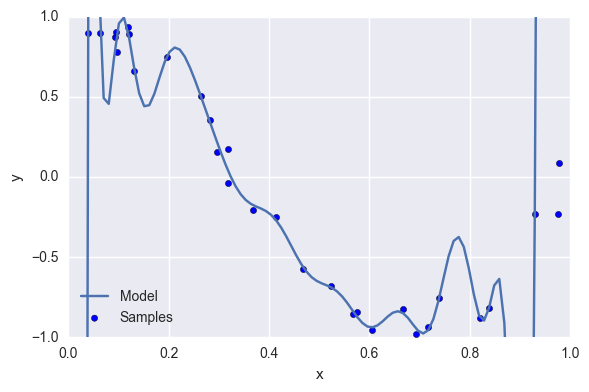

In [9]:
@interact(degree=(1,25))
def polyRegression(degree=1):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.scatter(X, y, label="Samples")
    formatGraph()

In [10]:
def polyMSE(degree):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    return mean_squared_error(y, pipeline.predict(X[:, np.newaxis]))

## Our MSE keeps decreasing... are we done?

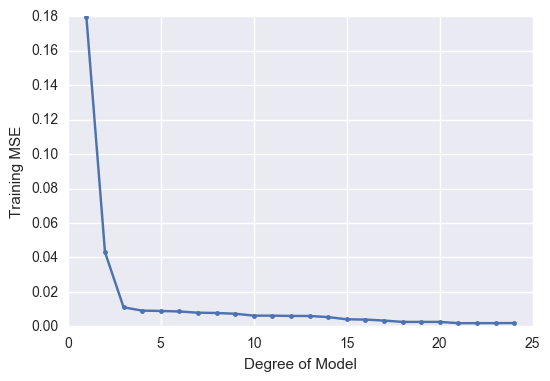

In [11]:
degree = range(1, 25)
plt.plot(degree, [polyMSE(d) for d in degree], '.-')
plt.ylabel('Training MSE'); plt.xlabel('Degree of Model')

## Generalization
- We have an intuition here that our model will perfom poorly on unseen data
- Our model has overfit the data in an effort to minimize MSE (which is what we told it to optimize :) )
- Need a better measure of model performance

## Holdout Method
- One method is to split our data set into a training and test data set.
- We will use the training data set to fit our model, but then use the test data set to evaluate its performance.

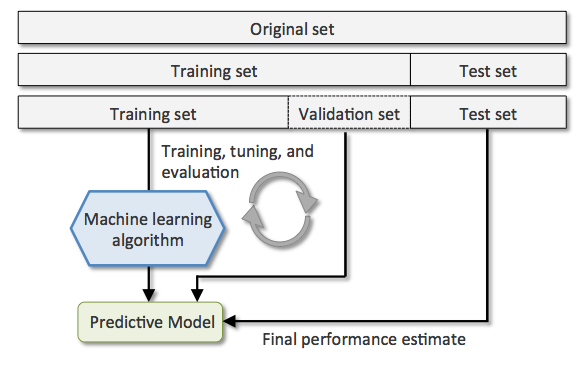

In [12]:
Image(filename='holdout.png', width=600) 

## K-fold Cross Validation
- Can take this a step further and reduce the affect of our choice in test/train split by repeating the procedure k times and averaging the result

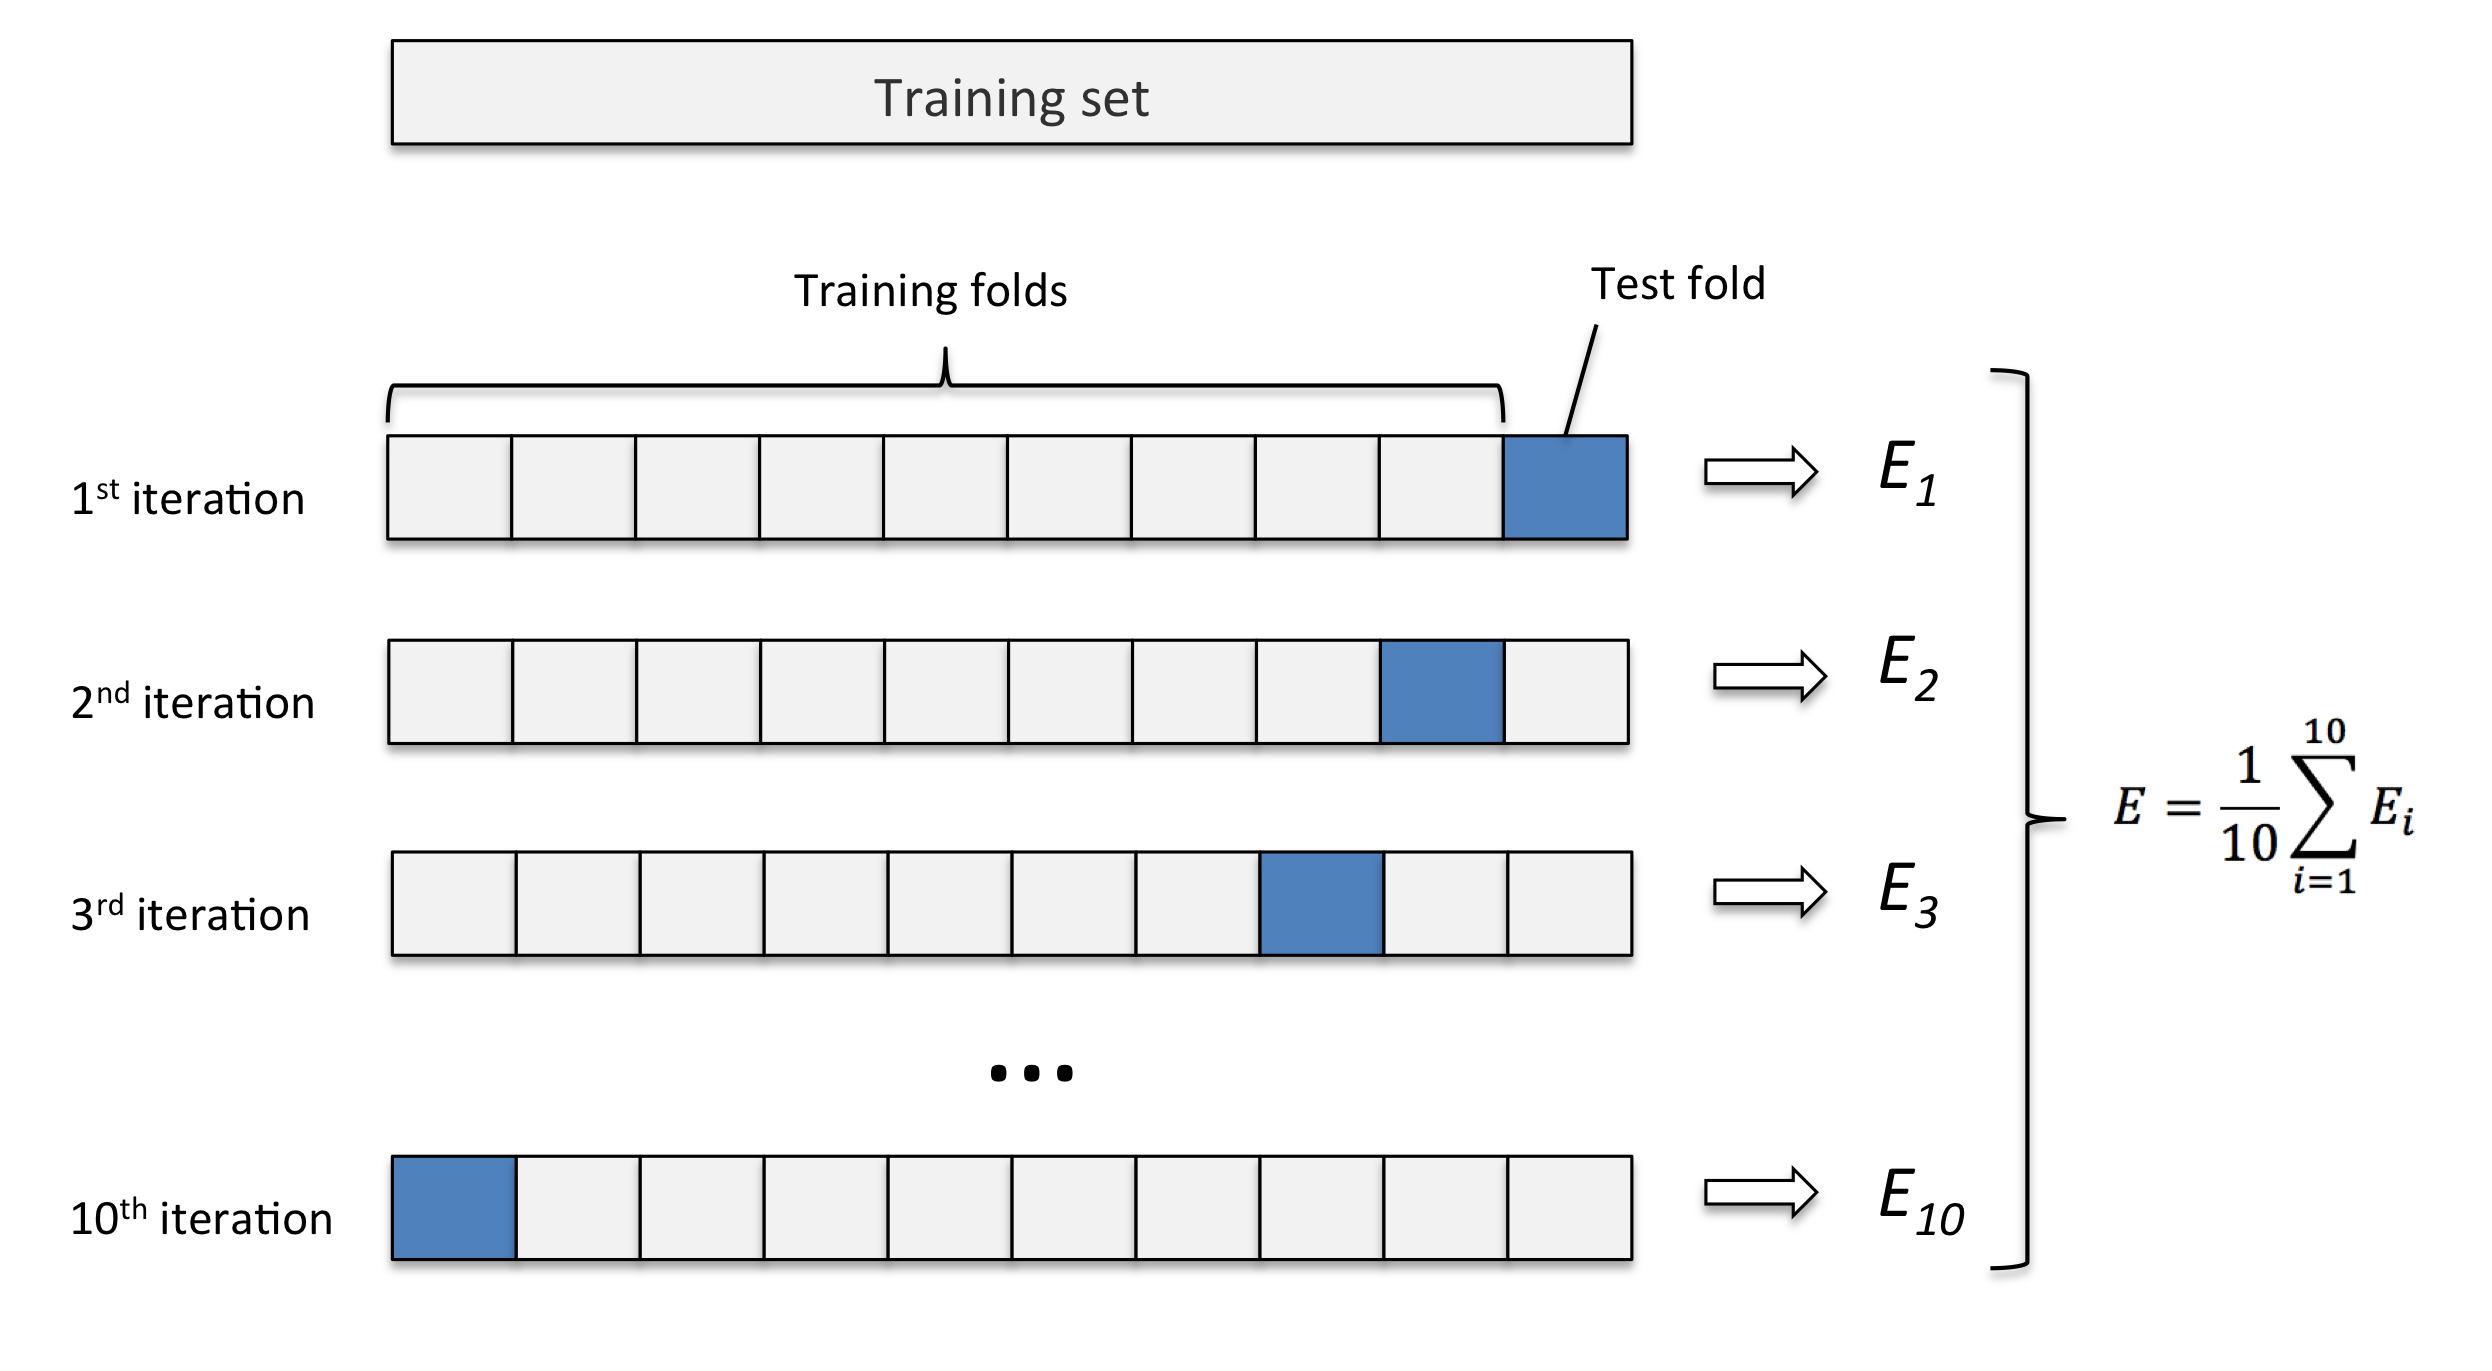

In [13]:
Image(filename='crossval.png', width=800) 

## Back to our example

In [14]:
def polyRegressionCross(degree):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    return -np.median(cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10))

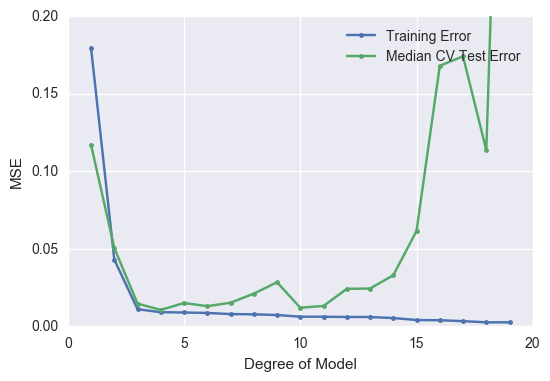

In [15]:
degree = range(1, 20)
plt.plot(degree, [polyMSE(d) for d in degree], '.-', label='Training Error')
plt.plot(degree, [polyRegressionCross(d) for d in degree], '.-', label='Median CV Test Error')
plt.ylim([0, 0.2])
plt.ylabel('MSE'); plt.xlabel('Degree of Model')
plt.legend()

## Next Steps
- We needed to manually look at our test error as a function of our model complexity
- Can build a preference towards less complex models with regularization by adding a term to our cost function that increases with complexity
- Can use cross validation for hyper parameter tuning